In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_classif
from scipy.stats import ttest_ind
import json
import os


# Set options

In [ ]:
THRESHOLD = 90
batch_corrected = True
nan_remove = True
scaler_term = 'minmax'
scaler = MinMaxScaler() if scaler_term=='minmax' else StandardScaler()

test_enc_name = '_BatchCor'+str(batch_corrected)+'_NanRem'+str(nan_remove)+'_'+str(scaler_term)

# Load config files

In [ ]:
with open('data/paths.json','r') as f:
    paths = json.load(f)

data_path = paths["data_path"]

# Get data

In [ ]:
df = pd.read_excel(os.path.join(data_path,"raw_data.xlsx"))
n_classes = len(np.unique(df['Lipid Class']))
df.head()

,Sample Number,Sample Submission Date,Sample Name,Sex,Tissue weight (mg),Treatment,Tissue Type,PND,Litter,Individual Lipid Species,Lipid Class,MRM Transition of each lipid species\n(Parent ion / Fragment ion),Lipid Species used as Internal Standard,Retention Time\n(min),UNCORRECTED\nPeak Area of Lipid Species,UNCORRECTED\nPeak Area of Internal Standard,UNCORRECTED\nNormalized Peak Area (Peak Area of Lipid Species / (Peak Area of Internal Standard * Tissue weight)),BATCH CORRECTED\nPeak Area of Lipid Species,BATCH CORRECTED\nPeak Area of Internal Standard,BATCH CORRECTED\nNormalized Peak Area (Peak Area of Lipid Species / (Peak Area of Internal Standard * Tissue weight))
0,1,09/2021,C20M1S,M,56,control,striatum,30,C20,SM(14:0)+H,SM,675.5 / 184.1,SM(18:1)+H_d9_SPLASH.IS,12.737513,4.116176e+06,6.142877e+07,0.001197,1.963161e+06,4.165659e+07,0.000842
1,1,09/2021,C20M1S,M,56,control,striatum,30,C20,SM(16:0)+H,SM,703.6 / 184.1,SM(18:1)+H_d9_SPLASH.IS,12.662914,2.433723e+07,6.142877e+07,0.007075,1.490595e+07,4.165659e+07,0.006390
2,1,09/2021,C20M1S,M,56,control,striatum,30,C20,SM(18:0)+H,SM,731.6 / 184.1,SM(18:1)+H_d9_SPLASH.IS,12.580159,1.432478e+08,6.142877e+07,0.041642,8.628739e+07,4.165659e+07,0.036989
3,1,09/2021,C20M1S,M,56,control,striatum,30,C20,SM(18:1)+H,SM,729.6 / 184.1,SM(18:1)+H_d9_SPLASH.IS,12.572303,1.268323e+08,6.142877e+07,0.036870,1.080535e+08,4.165659e+07,0.046320
4,1,09/2021,C20M1S,M,56,control,striatum,30,C20,SM(20:0)+H,SM,759.6 / 184.1,SM(18:1)+H_d9_SPLASH.IS,12.486523,5.419340e+06,6.142877e+07,0.001575,2.723486e+06,4.165659e+07,0.001167


## Select normalized or unnormalized data

In [ ]:
metadata = df.iloc[:,:11]
if batch_corrected:
    data = pd.concat([metadata, df.iloc[:,19]],axis=1)
else:
    data = pd.concat([metadata, df.iloc[:,16]],axis=1)
data.head()

,Sample Number,Sample Submission Date,Sample Name,Sex,Tissue weight (mg),Treatment,Tissue Type,PND,Litter,Individual Lipid Species,Lipid Class,BATCH CORRECTED\nNormalized Peak Area (Peak Area of Lipid Species / (Peak Area of Internal Standard * Tissue weight))
0,1,09/2021,C20M1S,M,56,control,striatum,30,C20,SM(14:0)+H,SM,0.000842
1,1,09/2021,C20M1S,M,56,control,striatum,30,C20,SM(16:0)+H,SM,0.006390
2,1,09/2021,C20M1S,M,56,control,striatum,30,C20,SM(18:0)+H,SM,0.036989
3,1,09/2021,C20M1S,M,56,control,striatum,30,C20,SM(18:1)+H,SM,0.046320
4,1,09/2021,C20M1S,M,56,control,striatum,30,C20,SM(20:0)+H,SM,0.001167


## Organize pivot table

In [ ]:
data_pivot = data.pivot(index=['Sample Name', 'Sex', 'Treatment', 'PND', 'Tissue Type', 'Sample Submission Date'], columns='Individual Lipid Species', values=data.columns[-1])
tot_lipids = data_pivot.shape[1] - 6

## Manage NaN

In [ ]:
if nan_remove:
    data_stats = data_pivot.reset_index().dropna(axis=1, thresh=0.9*data_pivot.shape[0]).fillna(1e-3*np.min(np.abs(data.iloc[:,-1])))
else:
    data_stats = data_pivot.reset_index().fillna(1e-3*np.min(np.abs(data.iloc[:,-1])))
data_stats.head()
lipids_ok = list(data_stats.columns[6:])

## Encode batch

In [ ]:
data_stats['Sample Submission Date'] = LabelEncoder().fit_transform(data_stats['Sample Submission Date'])
data_stats['Treatment'] = LabelEncoder().fit_transform(data_stats['Treatment'])
data_stats['Sample Submission Date'].unique()

array([0, 1])

## Log transform

In [ ]:
data_np = data_stats.values[:,6:]
data_np = np.log10(data_np.astype('float64'))
print(data_np.shape)

(72, 372)


## Visualize data distribution

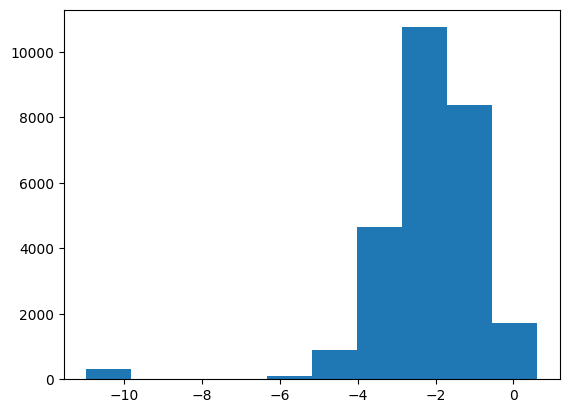

In [ ]:
plt.figure()
plt.hist(data_np.flatten())
plt.show()

# Normalize data

In [ ]:
data_norm = scaler.fit_transform(data_np)

## Visualize normalized data distribution

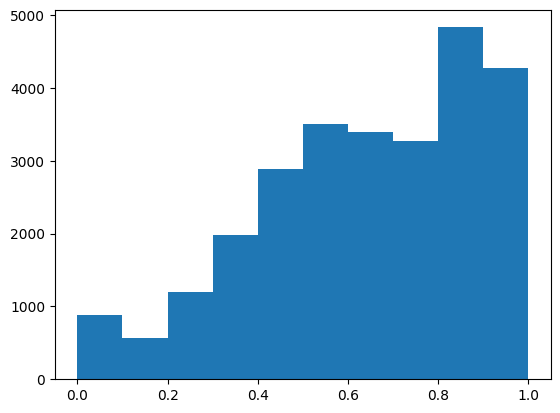

In [ ]:
plt.figure()
plt.hist(data_norm.flatten())
plt.show()

# PCA

In [ ]:
pca = PCA()
data_pca = pca.fit_transform(data_norm)
print(data_pca.shape)

(72, 72)


## Latent curve

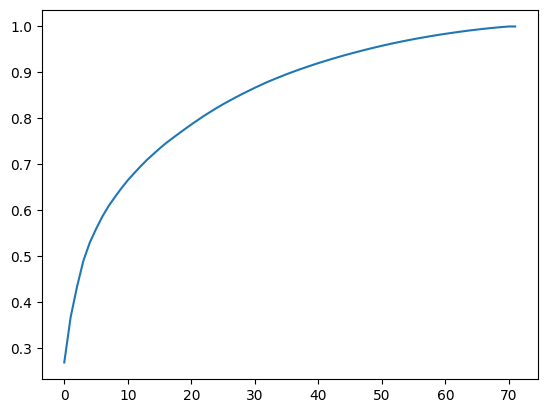

In [ ]:
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.show()

# T-test

In [ ]:
p_values = [
    [
        d,
        ttest_ind(data_pca[data_stats['Sample Submission Date']==0, d], data_pca[data_stats['Sample Submission Date']==1, d])[1],
        ttest_ind(data_pca[data_stats['Treatment']==0, d], data_pca[data_stats['Treatment']==1, d])[1],
    ]
    for d in range(data_pca.shape[1])
]
p_values = np.asarray(p_values)
print(p_values.shape)

(72, 3)


C:\Users\smran\AppData\Local\Temp\ipykernel_22800\260942847.py:4: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  ttest_ind(data_pca[data_stats['Sample Submission Date']==0, d], data_pca[data_stats['Sample Submission Date']==1, d])[1],
C:\Users\smran\AppData\Local\Temp\ipykernel_22800\260942847.py:5: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  ttest_ind(data_pca[data_stats['Treatment']==0, d], data_pca[data_stats['Treatment']==1, d])[1],


# Visualize data after PCA

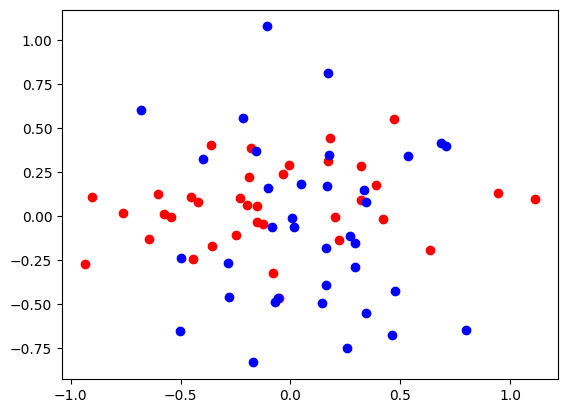

In [ ]:
plt.scatter(data_pca[data_stats['Treatment']==0, 14], data_pca[data_stats['Treatment']==0, 21],c="red")
plt.scatter(data_pca[data_stats['Treatment']==1, 14], data_pca[data_stats['Treatment']==1, 21],c="blue")
plt.show()

# Isolate significant PCs

In [ ]:
print(f'{np.sum(p_values[:,1]<0.05)} significant pc with respect to date')
print(f'{np.sum(p_values[:,2]<0.05)} significant pc with respect to date')
print(f'{np.sum((p_values[:,2]<0.05)*(p_values[:,1]<0.05))} significant pc with respect to both')

significant_pc = np.where(p_values[:,2]<0.05)[0]

4 significant pc with respect to date
2 significant pc with respect to date
0 significant pc with respect to both


# Isolate significant lipids

In [ ]:
significant_components = pca.components_[significant_pc,:]
print(significant_components.shape)
max_values = np.max(np.abs(significant_components), axis=0)
print(max_values.shape)

(2, 372)
(372,)


In [ ]:
ths = np.percentile(np.abs(pca.components_.flatten()), THRESHOLD)
idx_significant_lipids = np.where(max_values>ths)[0]
n_significant_lipids = len(idx_significant_lipids)
print(f'{n_significant_lipids} ({n_significant_lipids/tot_lipids*100:.2f}% of original total) significant lipids found')
significant_lipids = [lipids_ok[i] for i in idx_significant_lipids]

55 (4.85% of original total) significant lipids found


In [ ]:
lipid_classes = np.unique([lipids_ok[i].split('(')[0] for i in idx_significant_lipids])
print(f'{len(lipid_classes)} ({len(lipid_classes)/n_classes*100:.2f}% of original total) lipid classes found')
print(lipid_classes)

14 (66.67% of original total) lipid classes found
['CE' 'CER' 'DAG' 'DCER' 'LPC' 'LPE' 'LPI' 'MAG' 'PC' 'PE' 'PG' 'PI' 'PS'
 'TAG']


In [ ]:
date_pc = np.where(p_values[:,1]<0.05)[0]
significant_components = pca.components_[date_pc,:]
max_values = np.max(np.abs(significant_components), axis=0)

idx_significant_lipids = np.where(max_values>ths)[0]
n_significant_lipids = len(idx_significant_lipids)
print(f'{n_significant_lipids} ({n_significant_lipids/tot_lipids*100:.2f}% of original total) date dependent lipids found')
date_lipids = [lipids_ok[i] for i in idx_significant_lipids]

107 (9.43% of original total) date dependent lipids found


## Save results

In [ ]:
with open(os.path.join('results','significant_lipid'+test_enc_name+'.txt'), 'w') as f:
    for l in significant_lipids:
        f.write(l+'\n')

with open(os.path.join('results','date_lipids'+test_enc_name+'.txt'), 'w') as f:
    for l in date_lipids:
        f.write(l+'\n')

with open(os.path.join('results','significant_lipid_classes'+test_enc_name+'.txt'), 'w') as f:
    for l in lipid_classes:
        f.write(l+'\n')

### EXAMPLE WITH PARTIAL LEAST SQUARE - DA

In [ ]:
from sklearn.cross_decomposition import PLSRegression
pls2_treatment = PLSRegression(n_components=72, scale = False)
pls2_date = PLSRegression(n_components=72, scale = False)
data_pls2_treatment = pls2_treatment.fit_transform(data_norm, data_stats['Treatment'].values)
data_pls2_date = pls2_date.fit_transform(data_norm, data_stats['Sample Submission Date'].values)


C:\Users\smran\AppData\Roaming\Python\Python39\site-packages\sklearn\cross_decomposition\_pls.py:304: UserWarning: Y residual is constant at iteration 56
  warnings.warn(f"Y residual is constant at iteration {k}")
C:\Users\smran\AppData\Roaming\Python\Python39\site-packages\sklearn\cross_decomposition\_pls.py:304: UserWarning: Y residual is constant at iteration 56
  warnings.warn(f"Y residual is constant at iteration {k}")


In [ ]:
p_values_pls2 = [
    [
        d,
        ttest_ind(data_pls2_date[0][data_stats['Sample Submission Date']==0, d], data_pls2_date[0][data_stats['Sample Submission Date']==1, d])[1],
        ttest_ind(data_pls2_treatment[0][data_stats['Treatment']==0, d], data_pls2_treatment[0][data_stats['Treatment']==1, d])[1],
    ]
    for d in range(data_pls2_treatment[0].shape[1])
]
p_values_pls2 = np.asarray(p_values_pls2)
print(p_values_pls2.shape)

(72, 3)


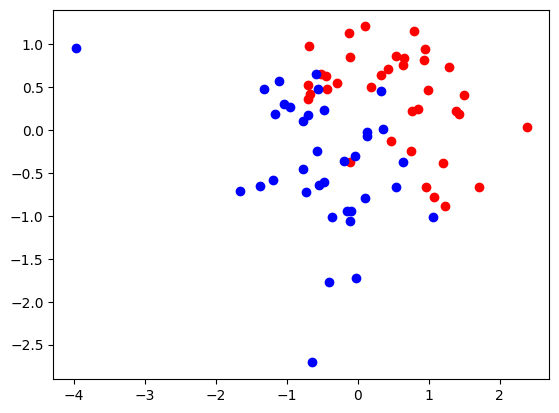

In [ ]:
plt.scatter(data_pls2_treatment[0][data_stats['Treatment']==0, 1], data_pls2_treatment[0][data_stats['Treatment']==0, 2],c="red")
plt.scatter(data_pls2_treatment[0][data_stats['Treatment']==1, 1], data_pls2_treatment[0][data_stats['Treatment']==1, 2],c="blue")
plt.show()

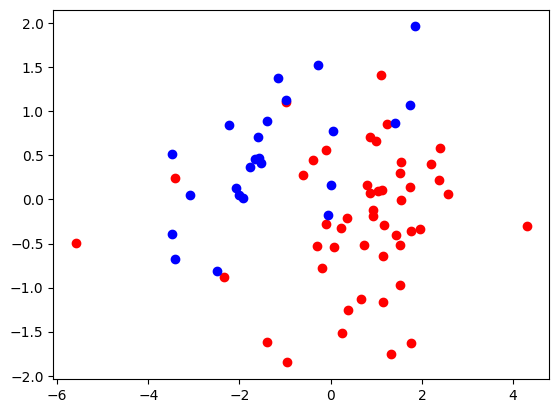

In [ ]:
plt.scatter(data_pls2_date[0][data_stats['Sample Submission Date']==0, 0], data_pls2_date[0][data_stats['Sample Submission Date']==0, 1],c="red")
plt.scatter(data_pls2_date[0][data_stats['Sample Submission Date']==1, 0], data_pls2_date[0][data_stats['Sample Submission Date']==1, 1],c="blue")
plt.show()

In [ ]:
print(f'{np.sum(p_values_pls2[:,1]<0.05)} significant pc with respect to date')
print(f'{np.sum(p_values_pls2[:,2]<0.05)} significant pc with respect to TREATMENT')
print(f'{np.sum((p_values_pls2[:,2]<0.05)*(p_values[:,1]<0.05))} significant pc with respect to both')

significant_pc_pls2_treatment = np.where(p_values_pls2[:,2]<0.05)[0]
significant_pc_pls2_date = np.where(p_values_pls2[:,1]<0.05)[0]
print(significant_pc_pls2_treatment)
print(significant_pc_pls2_date)

6 significant pc with respect to date
5 significant pc with respect to TREATMENT
1 significant pc with respect to both
[0 1 2 3 4]
[0 1 2 3 4 5]


In [ ]:
significant_components_pls2_treatment = pls2_treatment.x_weights_.T[significant_pc_pls2_treatment,:]
max_values_pls2_treatment = np.max(np.abs(significant_components_pls2_treatment), axis = 0)

In [ ]:
ths_pls2_treatment = np.percentile(np.abs(pls2_treatment.x_weights_.T.flatten()), THRESHOLD)

In [ ]:
idx_significant_lipids_pls2_treatment = np.where(max_values_pls2_treatment>ths_pls2_treatment)[0]
n_significant_lipids_pls2_treatment = len(idx_significant_lipids_pls2_treatment)
print(f'{n_significant_lipids_pls2_treatment} ({n_significant_lipids_pls2_treatment/tot_lipids*100:.2f}% of original total) significant lipids found')
significant_lipids_pls2_treatment = [lipids_ok[i] for i in idx_significant_lipids_pls2_treatment]

198 (17.44% of original total) significant lipids found


In [ ]:
significant_components_pls2_date = pls2_date.x_weights_.T[significant_pc_pls2_date,:]
max_values_pls2_date = np.max(np.abs(significant_components_pls2_date), axis = 0)

In [ ]:
ths_pls2_date = np.percentile(np.abs(pls2_date.x_weights_.T.flatten()), THRESHOLD)

In [ ]:
idx_significant_lipids_pls2_date = np.where(max_values_pls2_date>ths_pls2_date)[0]
n_significant_lipids_pls2_date = len(idx_significant_lipids_pls2_date)
print(f'{n_significant_lipids_pls2_date} ({n_significant_lipids_pls2_date/tot_lipids*100:.2f}% of original total) significant lipids found')
significant_lipids_pls2_date = [lipids_ok[i] for i in idx_significant_lipids_pls2_date]

204 (17.97% of original total) significant lipids found


In [ ]:
lipid_classes_pls2_treatment = np.unique([lipids_ok[i].split('(')[0] for i in idx_significant_lipids_pls2_treatment])
print(f'{len(lipid_classes_pls2_treatment)} ({len(lipid_classes_pls2_treatment)/n_classes*100:.2f}% of original total) lipid classes found')
print(lipid_classes_pls2_treatment)

16 (76.19% of original total) lipid classes found
['CER' 'DAG' 'DCER' 'HCER' 'LPC' 'LPE' 'LPI' 'LPS' 'MAG' 'PC' 'PE' 'PG'
 'PI' 'PS' 'SM' 'TAG']


In [ ]:
lipid_classes_pls2_date = np.unique([lipids_ok[i].split('(')[0] for i in idx_significant_lipids_pls2_date])
print(f'{len(lipid_classes_pls2_date)} ({len(lipid_classes_pls2_date)/n_classes*100:.2f}% of original total) lipid classes found')
print(lipid_classes_pls2_date)

17 (80.95% of original total) lipid classes found
['CE' 'CER' 'DAG' 'DCER' 'HCER' 'LPC' 'LPE' 'LPI' 'LPS' 'MAG' 'PC' 'PE'
 'PG' 'PI' 'PS' 'SM' 'TAG']


In [ ]:
unique_set_treatment = set(significant_lipids_pls2_treatment).difference(set(significant_lipids_pls2_date))
unique_list_treatment = list(unique_set_treatment)

In [ ]:
with open(os.path.join('results','significant_lipids_pls2_treatment'+test_enc_name+'.txt'), 'w') as f:
    for l in significant_lipids_pls2_treatment:
        f.write(l+'\n')

In [ ]:
with open(os.path.join('results','significant_lipids_pls2_date'+test_enc_name+'.txt'), 'w') as f:
    for l in significant_lipids_pls2_date:
        f.write(l+'\n')

In [ ]:
with open(os.path.join('results','significant_lipids_pls2_unique_treatment'+test_enc_name+'.txt'), 'w') as f:
    for l in unique_list_treatment:
        f.write(l+'\n')